# Make of a neural network with numpy

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_9233/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [2]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [3]:
# Class constructiong a generic loss function

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        raise NotImplementedError

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        raise NotImplementedError

# Mean square error Loss

class MeanSquareError(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return 2 * (predicted - actual) / len(actual)
    
# Categorical cross entropy Loss

class CrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum(actual * np.log(predicted)) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return (actual / predicted) / len(actual)

### Constructring the different layers with classes

In [4]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Stocking the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int, Seed: bool = False) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        if Seed == True:
            np.random.seed(2)

        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs
        
        # Compute the feed forward pass
        """
        (b,i) @ (i,o) + (1,o) = (b,o)
        """
        return inputs @ self.params["w"] + self.params["b"]
        
     
        
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        """
        (i,b) @ (b,o) = (i,o)
        """
        self.grads["b"] = grad
        """
        (b,o) 
        """
        # Compute the feed backward pass
        """
        (b,o) @ (o,i) = (b,i)
        """
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))

def relu(x: Tensor) -> Tensor:
    return np.maximum(0,x)

def relu_prime(x: Tensor) -> Tensor:
    return np.where(x <= 0, 0, 1)

# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad

### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [5]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        self.lr = lr 
        """
        Learning rate
        """
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
                for name in layer.params.keys():
                    layer.params[name] = layer.params[name] - self.lr * layer.grads[name]

### Class defining how to organize the data in series of batch

In [6]:
Batch = NamedTuple("Batch", [("inputs", Tensor), ("targets", Tensor)])


class DataIterator:
    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        raise NotImplementedError

        
class BatchIterator(DataIterator):
    def __init__(self, batch_size: int = 32, shuffle: bool = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)

        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

### Defining the training routine of the network

In [7]:
def train(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator: DataIterator = BatchIterator(),
        num_epochs: int = 5000,
        UseBatch: bool = False) -> None:

    Loss_list : Sequence = []
    Acc_list : Sequence = []
        
    if UseBatch == True:

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            for batch in iterator(inputs, targets):

                Batch_loss : Sequence = []
                Batch_grad : Sequence = []
                Batch_acc : Sequence = [] 

                predicted = net.forward(batch[0])
                Batch_loss.append(loss.loss(predicted, batch[1]))
                grad = loss.grad(predicted, batch[1])
                Batch_grad.append(grad) 
                net.backward(grad)
                net.optimize()
                
                Batch_acc.append(np.mean(predicted.round()==batch[1]) * 100)

                
            epoch_loss = np.mean(Batch_loss)
            epoch_acc = np.mean(Batch_acc)

            Loss_list.append(epoch_loss)
            Acc_list.append(epoch_acc)
                    
            # Print status every 100 iterations
            if epoch % 100 == 0:
                print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)
        
    else:
            
        for epoch in range(num_epochs):
            epoch_loss = 0.0

            predicted = net.forward(inputs)
            epoch_loss = loss.loss(predicted, targets)
            epoch_grad = loss.grad(predicted, targets)
            net.backward(epoch_grad)
            net.optimize()
                
            epoch_acc = np.mean(predicted.round()==targets) * 100

            Loss_list.append(epoch_loss)
            Acc_list.append(epoch_acc)
                    
            # Print status every 100 iterations
            if epoch % 100 == 0:
                print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)

        
    print("Targets - Predictions - Results")
    for y, z in zip(targets, predicted):
        print(f'{y} => {z} => {z.round()}')
        
        
    plt.plot(Acc_list)
    plt.ylabel('Accuracy')
    plt.xlabel("Epochs:")
    plt.show()
    
    plt.plot(Loss_list)
    plt.ylabel('Loss')
    plt.xlabel("Epochs:")
    plt.show()


### Validation Process

In [8]:
def validate(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator: DataIterator = BatchIterator(),
        UseBatch: bool = False) -> None:
        
    if UseBatch == True:
            
        for batch in iterator(inputs, targets):

            Batch_loss : Sequence = []
            Batch_acc : Sequence = [] 

            predicted = net.forward(batch[0])
            
            Batch_loss.append(loss.loss(predicted, batch[1]))   
            Batch_acc.append(np.mean(predicted.round()==batch[1]) * 100)
   
        val_loss = np.mean(Batch_loss)
        val_acc = np.mean(Batch_acc)
        
    else:

        predicted = net.forward(inputs)
        
        val_loss = loss.loss(predicted, targets)
        val_acc = np.mean(predicted.round()==targets) * 100


    print(" Loss = ", val_loss," Acc = ", val_acc)

    print("Targets - Predictions - Results")
    for y, z in zip(targets, predicted):
        print(f'{y} => {z} => {z.round()}')

In [9]:
lines: int = 20000

# 2 types of dataset : 12 variables and 3 variables

dataset1_train = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), nrows=lines)

dataset2_train = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], nrows=lines)


dataset1_validation = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines+1, nrows=lines)

dataset2_validation = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], skiprows=lines+1, nrows=lines)



labels_train = pd.read_csv('dataset_modif2.csv', usecols=["label"], nrows=lines)

labels_validation = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines+1, nrows=lines)

Epoch =  0  Loss =  0.6749851975007778  Acc =  35.0
Epoch =  100  Loss =  0.31208811610165993  Acc =  63.0
Epoch =  200  Loss =  0.29347492692445165  Acc =  63.0
Epoch =  300  Loss =  0.2912957170405994  Acc =  62.5
Epoch =  400  Loss =  0.2907348706595992  Acc =  62.0
Epoch =  500  Loss =  0.2894039028712329  Acc =  63.5
Epoch =  600  Loss =  0.28567526968404544  Acc =  64.5
Epoch =  700  Loss =  0.281639008330197  Acc =  64.5
Epoch =  800  Loss =  0.2764952874652259  Acc =  66.5
Epoch =  900  Loss =  0.26753409462243677  Acc =  70.0
Epoch =  1000  Loss =  0.26618653384997215  Acc =  71.0
Epoch =  1100  Loss =  0.26423993300685134  Acc =  72.0
Epoch =  1200  Loss =  0.26116347693659514  Acc =  73.0
Epoch =  1300  Loss =  0.25636975201443774  Acc =  74.0
Epoch =  1400  Loss =  0.24958543674508385  Acc =  74.5
Epoch =  1500  Loss =  0.24102154073698956  Acc =  74.5
Epoch =  1600  Loss =  0.23271686247468992  Acc =  75.5
Epoch =  1700  Loss =  0.2264551304041133  Acc =  76.0
Epoch =  180

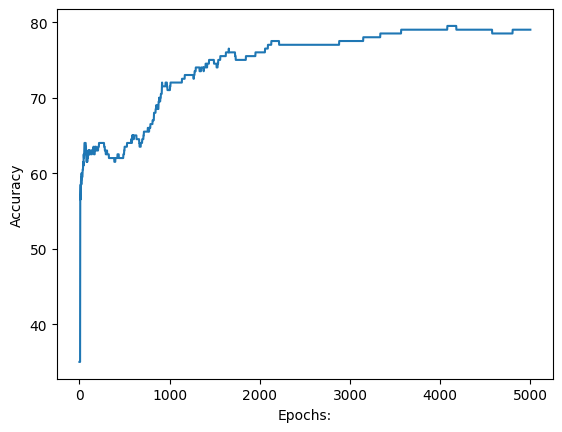

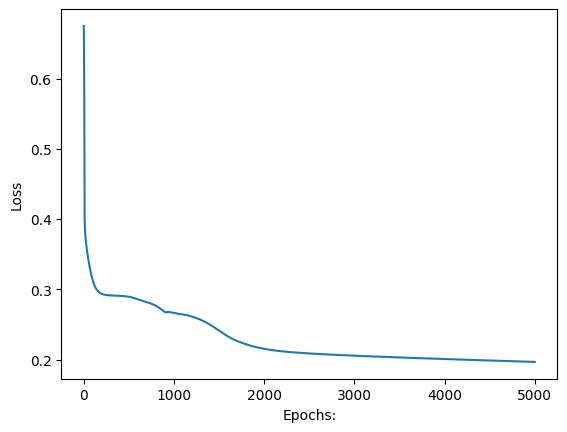

 Loss =  0.2398142209856287  Acc =  75.0
Targets - Predictions - Results
[0] => [1.18149466] => [1.]
[2] => [1.14747818] => [1.]
[0] => [-0.00527493] => [-0.]
[1] => [1.46395193] => [1.]
[0] => [0.01499149] => [0.]
[0] => [0.09517447] => [0.]
[1] => [2.05562753] => [2.]
[2] => [-0.05885385] => [-0.]
[2] => [1.5511399] => [2.]
[0] => [1.39820788] => [1.]
[2] => [1.06758806] => [1.]
[1] => [0.10660871] => [0.]
[0] => [1.2716319] => [1.]
[2] => [1.75045265] => [2.]
[2] => [1.40357215] => [1.]
[0] => [0.08969551] => [0.]
[1] => [1.39763304] => [1.]
[1] => [1.25494825] => [1.]
[0] => [1.86545711] => [2.]
[2] => [1.27334401] => [1.]
[2] => [0.09479443] => [0.]
[2] => [0.8650805] => [1.]
[1] => [1.48819046] => [1.]
[2] => [0.02217802] => [0.]
[2] => [1.55403895] => [2.]
[0] => [2.05127025] => [2.]
[0] => [0.19969882] => [0.]
[2] => [0.02023004] => [0.]
[0] => [1.20811507] => [1.]
[0] => [1.11061118] => [1.]
[0] => [0.63070936] => [1.]
[1] => [0.11182579] => [0.]
[2] => [1.56770616] => [2.]
[1

' train(net2, inputs=dataset1_train.values, targets=labels_train.values, loss=MeanSquareError(), \n      UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value), num_epochs=10000)\n\nvalidate(net2, inputs=dataset1_validation.values, targets=labels_validation.values, loss=MeanSquareError(), \n         UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value)) '

In [10]:
# Using 2 instances of the same network for different number of epochs for training

seed_value: bool = True

net1 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
])

net2 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
])

batch_value: bool = True
batch_num: int = 200
shuffle_value: bool = False

train(net1, inputs=dataset1_train.values, targets=labels_train.values, loss=MeanSquareError(), 
      UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value), num_epochs=5000)

validate(net1, inputs=dataset1_validation.values, targets=labels_validation.values, loss=MeanSquareError(), 
         UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value))


""" train(net2, inputs=dataset1_train.values, targets=labels_train.values, loss=MeanSquareError(), 
      UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value), num_epochs=10000)

validate(net2, inputs=dataset1_validation.values, targets=labels_validation.values, loss=MeanSquareError(), 
         UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value)) """